In [3]:
pip install torch torchvision transformers huggingface_hub pickle5


  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pickle5' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pickle5'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [106 lines of output]
      /home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/setuptools/dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing th

In [4]:
# Import necessary libraries
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Load the BLIP model for image captioning from Hugging Face
def load_captioning_model():
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    return processor, model

# Initialize the model
processor, model = load_captioning_model()
print("Image captioning model loaded successfully!")

/home/dac/miniconda3/envs/gradcam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Image captioning model loaded successfully!


In [5]:
# Function to load image from URL or local path
def load_image(image_source):
    """Load image from URL or local file path"""
    try:
        if image_source.startswith('http'):
            response = requests.get(image_source)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            image = Image.open(image_source).convert('RGB')
        return image
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Function to generate captions
def generate_caption(image_source, beam_size=5, max_length=50):
    """Generate captions for an image using BLIP model"""
    try:
        # Load the image
        image = load_image(image_source)
        if image is None:
            return ["Error: Could not load image"]
        
        # Process the image
        inputs = processor(image, return_tensors="pt")
        
        # Generate caption with beam search
        with torch.no_grad():
            out = model.generate(
                **inputs, 
                max_length=max_length,
                num_beams=beam_size,
                num_return_sequences=beam_size,
                early_stopping=True
            )
        
        # Decode the generated captions
        captions = []
        for i in range(beam_size):
            caption = processor.decode(out[i], skip_special_tokens=True)
            captions.append(caption)
        
        return captions
    
    except Exception as e:
        print(f"Error generating caption: {e}")
        return ["Error generating caption"]

# Function to display image with captions
def caption_image(image_source, beam_size=5):
    """Display image with generated captions"""
    # Load and display image
    image = load_image(image_source)
    if image is None:
        return
    
    # Generate captions
    captions = generate_caption(image_source, beam_size)
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')
    
    # Display captions
    plt.subplot(1, 2, 2)
    plt.axis('off')
    caption_text = "Generated Captions:\n\n"
    for i, caption in enumerate(captions, 1):
        caption_text += f"{i}. {caption}\n\n"
    
    plt.text(0.1, 0.9, caption_text, fontsize=12, verticalalignment='top',
             transform=plt.gca().transAxes, wrap=True,
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return captions


Test Image 1


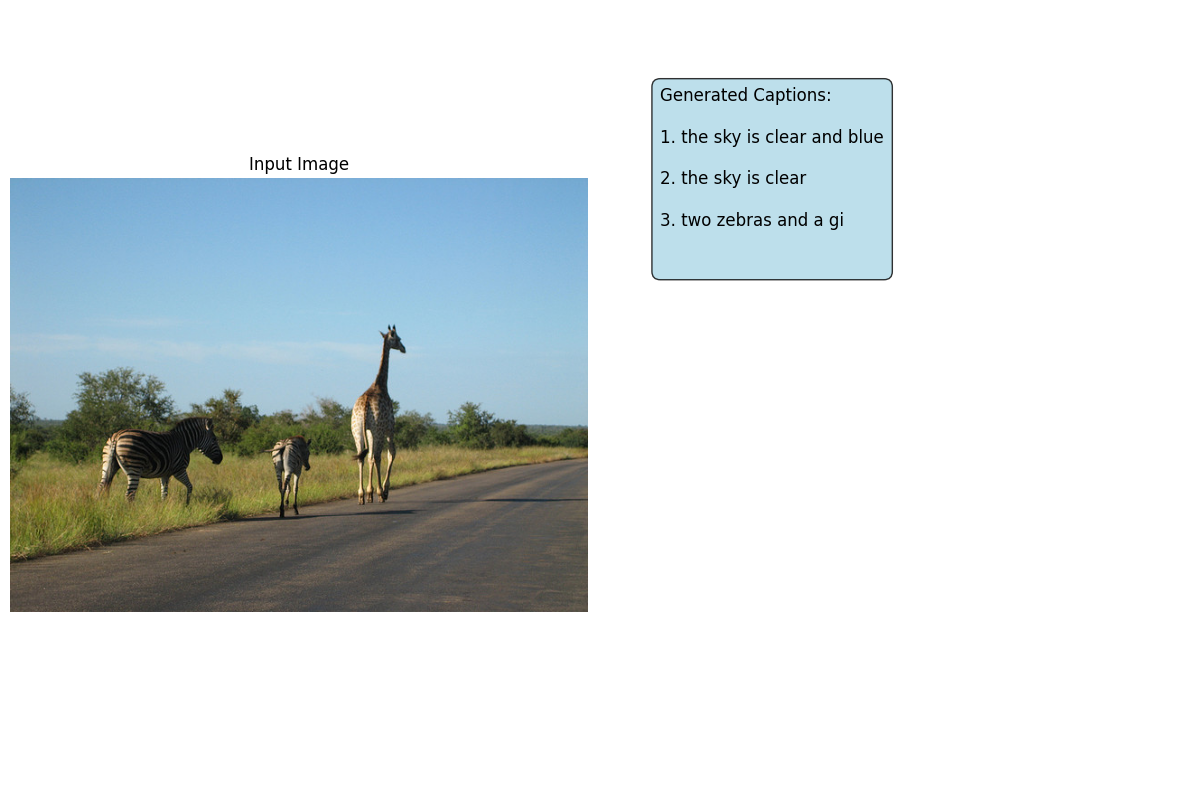


Generated Captions:
1. the sky is clear and blue
2. the sky is clear
3. two zebras and a gi

Test Image 2


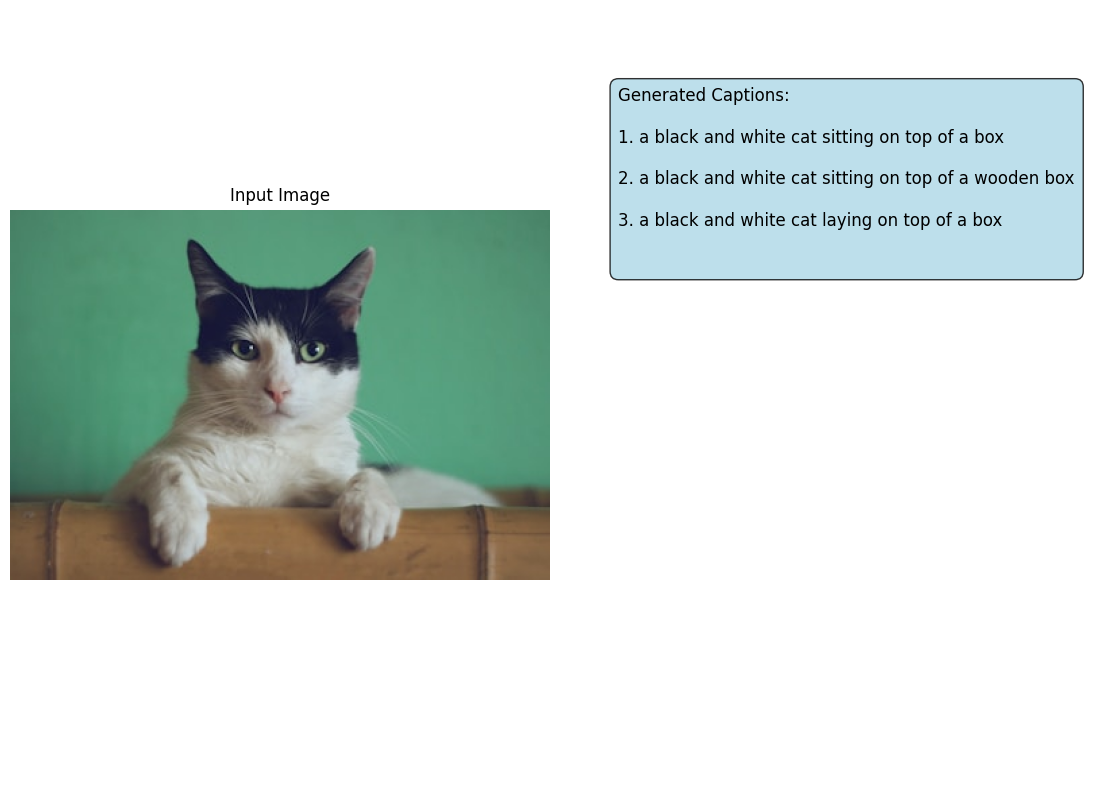


Generated Captions:
1. a black and white cat sitting on top of a box
2. a black and white cat sitting on top of a wooden box
3. a black and white cat laying on top of a box

Test Image 3


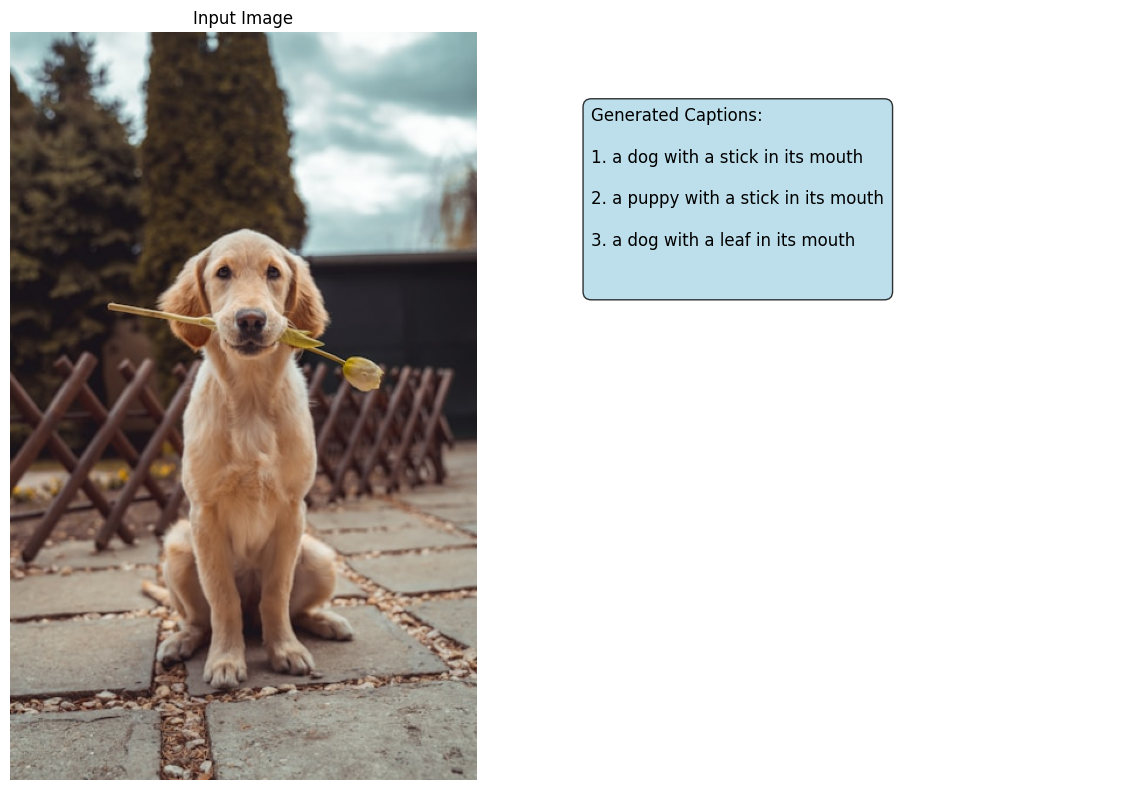


Generated Captions:
1. a dog with a stick in its mouth
2. a puppy with a stick in its mouth
3. a dog with a leaf in its mouth


In [6]:
# Test with example images
test_images = [
    "http://images.cocodataset.org/train2017/000000505539.jpg",
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",  # cat
    "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400",    # dog
]

# Generate captions for test images
for i, image_url in enumerate(test_images, 1):
    print(f"\n{'='*60}")
    print(f"Test Image {i}")
    print(f"{'='*60}")
    captions = caption_image(image_url, beam_size=3)
    
    print("\nGenerated Captions:")
    for j, caption in enumerate(captions, 1):
        print(f"{j}. {caption}")

Caption: 'a dog with a stick in its mouth'  |  Word: 'stick'


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]



Tokens: ['a', 'dog', 'with', 'a', 'stick', 'in', 'its', 'mouth']


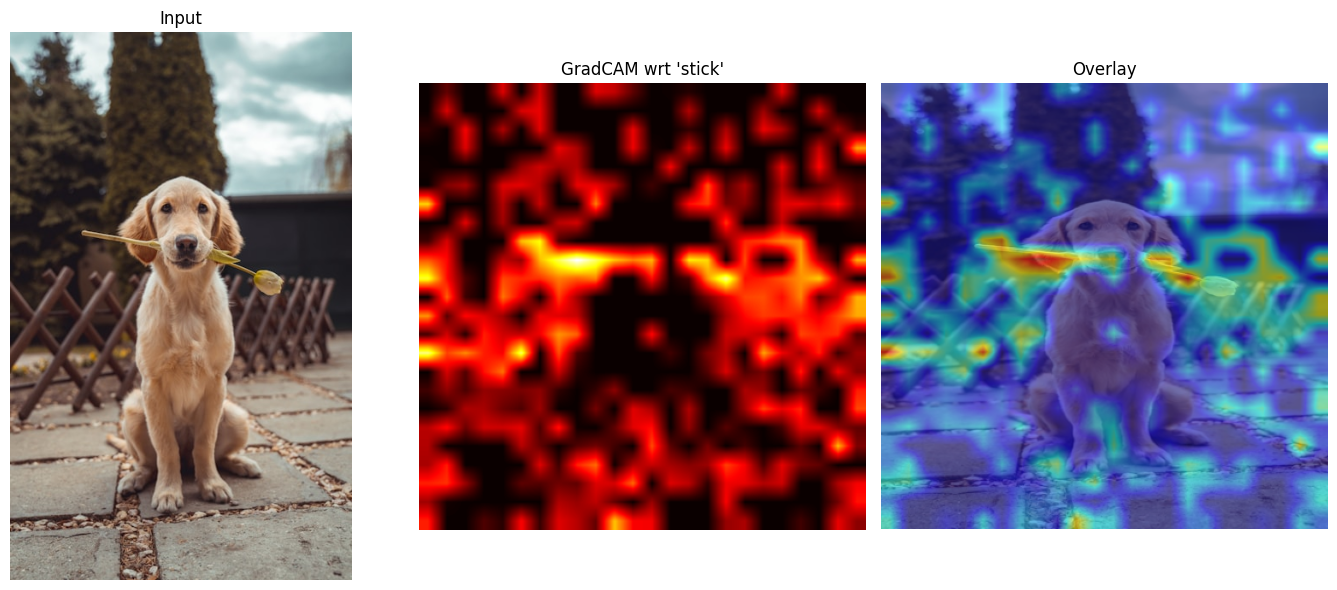

In [12]:
# Corrected caption-conditioned GradCAM for BLIP
import gc, torch, requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# --- Utility: clear hooks ---
def clear_all_hooks(model):
    def remove_hooks(module):
        for attr in ("_forward_hooks", "_backward_hooks", "_forward_pre_hooks"):
            if hasattr(module, attr):
                getattr(module, attr).clear()
        for child in module.children():
            remove_hooks(child)
    remove_hooks(model)

# --- CONFIG ---
CAPTION = "a dog with a stick in its mouth"
WORD_TO_VISUALIZE = "stick"
IMAGE_URL = "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400"

print(f"Caption: '{CAPTION}'  |  Word: '{WORD_TO_VISUALIZE}'")

# --- Imports ---
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from transformers import BlipProcessor, BlipForConditionalGeneration

# --- Load model + processor ---
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# --- Load image ---
def load_image(image_source):
    if str(image_source).startswith("http"):
        r = requests.get(image_source)
        img = Image.open(BytesIO(r.content)).convert("RGB")
    else:
        img = Image.open(image_source).convert("RGB")
    return img

image = load_image(IMAGE_URL)

# Preprocess inputs
inputs = processor(image, text=CAPTION, return_tensors="pt").to(device)
input_tensor = inputs["pixel_values"]  # for GradCAM
text_ids = inputs["input_ids"]

# --- Wrapper: tie GradCAM target to one caption token ---
class BlipCaptionWrapper(torch.nn.Module):
    def __init__(self, blip_model, token_index):
        super().__init__()
        self.blip = blip_model
        self.token_index = token_index

    def forward(self, x):
        # BLIP needs both vision and text
        outputs = self.blip(pixel_values=x, input_ids=text_ids, return_dict=True)
        logits = outputs.logits  # [batch, seq_len, vocab]
        # pick one scalar: the logit for the word at token_index
        target_logit = logits[:, self.token_index, :].mean(dim=-1, keepdim=True)
        return target_logit

# --- Pick token index for word ---
tokens = processor.tokenizer.tokenize(CAPTION)
print("Tokens:", tokens)
try:
    token_index = tokens.index(WORD_TO_VISUALIZE)
except ValueError:
    token_index = 0  # fallback to first token

wrapped_model = BlipCaptionWrapper(model, token_index)

# --- Target layer: last encoder block norm ---
target_layer = model.vision_model.encoder.layers[-1].layer_norm1

# --- Reshape transform: ViT patch -> H,W ---
def reshape_transform(tensor):
    if isinstance(tensor, tuple):
        tensor = tensor[0]
    b, seq_len, hidden = tensor.shape
    num_patches = seq_len - 1
    spatial = int(np.sqrt(num_patches))
    tensor = tensor[:, 1:, :]  # drop CLS
    tensor = tensor.reshape(b, spatial, spatial, hidden)
    return tensor.permute(0, 3, 1, 2).contiguous()

# --- Run GradCAM ---
cam = GradCAM(model=wrapped_model, target_layers=[target_layer], reshape_transform=reshape_transform)
grayscale_cam = cam(input_tensor=input_tensor)[0]

# --- Visualize ---
def denormalize_image(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    arr = tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    arr = std * arr + mean
    return np.clip(arr, 0, 1)

rgb_img = denormalize_image(input_tensor)
overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(14,6))
plt.subplot(1,3,1); plt.imshow(image); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(grayscale_cam, cmap="hot"); plt.title(f"GradCAM wrt '{WORD_TO_VISUALIZE}'"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]



find_vit_like_target_layer: selected module: LayerNorm


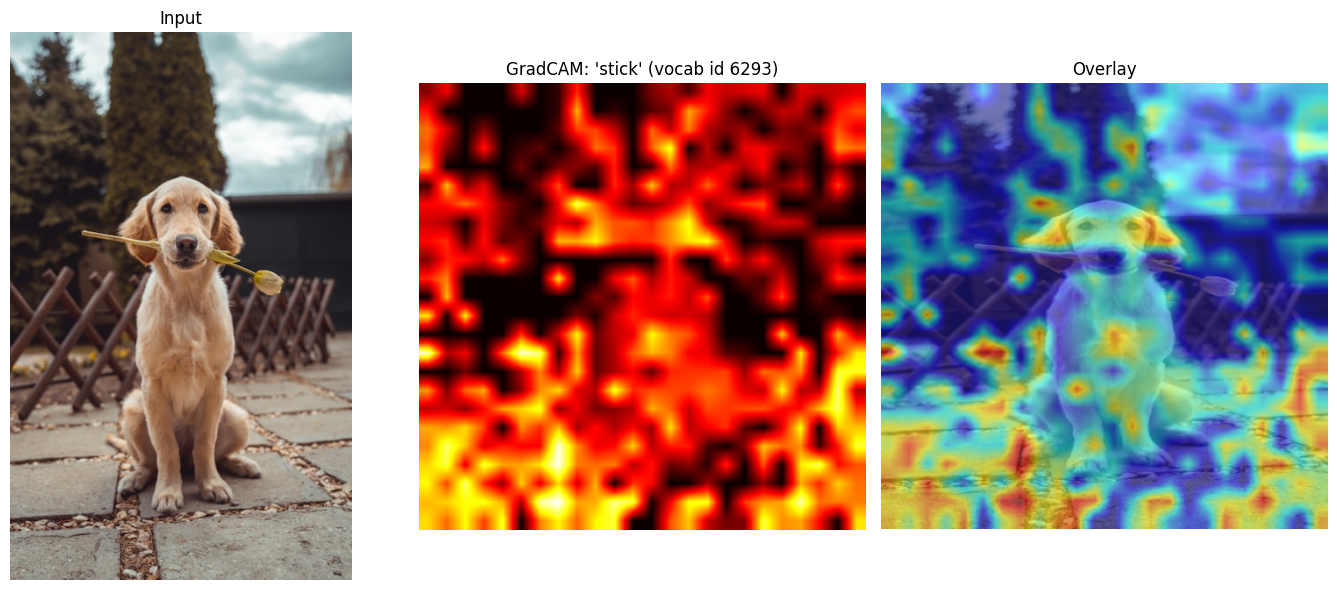

In [13]:
# Corrected caption-conditioned GradCAM for BLIP (word-specific)
import gc
import torch
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from transformers import BlipProcessor, BlipForConditionalGeneration

# ---------------------------
# Helpers
# ---------------------------
def load_image(url_or_path):
    if str(url_or_path).startswith("http"):
        r = requests.get(url_or_path, timeout=30)
        r.raise_for_status()
        return Image.open(BytesIO(r.content)).convert("RGB")
    return Image.open(url_or_path).convert("RGB")

def denorm(t: torch.Tensor):
    """Denormalize tensor of shape [1,3,H,W] to HxWx3 numpy in [0,1]."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    arr = t.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    arr = std * arr + mean
    return np.clip(arr, 0, 1)

def clear_all_hooks(model):
    """Remove any saved hooks/extra attributes potentially left by previous runs."""
    for m in model.modules():
        # common attributes some hooks implementations use
        for attr in ("_forward_hooks", "_backward_hooks", "_forward_pre_hooks"):
            if hasattr(m, attr):
                getattr(m, attr).clear()
        # remove custom saved tensors/flags if present
        for nm in ("save_attention", "get_attn_gradients", "get_attention_map"):
            if hasattr(m, nm):
                try:
                    delattr(m, nm)
                except Exception:
                    pass

def find_vit_like_target_layer(vision_model, input_tensor):
    """
    Try to find a module inside vision_model whose forward output is [B, N, C]
    (i.e. transformer token output). This attaches temporary forward hooks and
    does a single forward pass through vision_model to inspect outputs.
    Returns: the selected module (nn.Module) or None.
    """
    outputs = []
    handles = []

    def make_hook(mod):
        def hook(mod, inp, out):
            # store (module, out) if out is a tensor and has dim==3
            if torch.is_tensor(out):
                outputs.append((mod, out.detach().cpu()))
        return hook

    # register hooks on all submodules
    for mod in vision_model.modules():
        try:
            h = mod.register_forward_hook(make_hook(mod))
            handles.append(h)
        except Exception:
            pass

    # Do a forward pass through the vision_model only (no text)
    try:
        # BLIP's vision_model forward takes pixel_values kwarg and returns BaseModelOutput
        _ = vision_model(pixel_values=input_tensor)
    except Exception as e:
        # attempt alternative call
        try:
            _ = vision_model(input_tensor)
        except Exception:
            # cleanup hooks and raise
            for h in handles:
                h.remove()
            raise

    # cleanup hooks
    for h in handles:
        h.remove()

    # prefer the last module whose output shape is [B, N, C] and N>1 (i.e. tokens incl cls)
    candidates = [(m, out) for (m, out) in outputs if out.dim() == 3 and out.shape[1] > 1]
    if not candidates:
        return None

    selected_mod = candidates[-1][0]
    # debug
    print("find_vit_like_target_layer: selected module:", selected_mod.__class__.__name__)
    return selected_mod

# reshape transform for ViT-like tokens -> [B,C,H,W]
def vit_reshape_transform(t):
    if isinstance(t, tuple):
        t = t[0]
    if not torch.is_tensor(t):
        t = torch.tensor(t)
    assert t.dim() == 3, f"Expected [B, N, C], got {tuple(t.shape)}"
    b, n, c = t.shape
    n_patches = n - 1  # drop CLS
    h = int(np.sqrt(n_patches))
    w = h
    assert h * w == n_patches, f"Non-square tokens: {n_patches}"
    t = t[:, 1:, :]              # drop CLS
    t = t.reshape(b, h, w, c)    # [B, H, W, C]
    t = t.permute(0, 3, 1, 2).contiguous()  # [B, C, H, W]
    return t

# ---------------------------
# Main
# ---------------------------
CAPTION = "a dog with a stick in its mouth"
WORD_TO_VISUALIZE = "stick"
IMAGE_URL = "https://images.unsplash.com/photo-1552053831-71594a27632d?w=400"

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Disable gradient checkpointing to avoid tuple outputs in hooks (defensive)
try:
    if hasattr(model.vision_model.encoder, "set_gradient_checkpointing"):
        model.vision_model.encoder.set_gradient_checkpointing(False)
    if hasattr(model.vision_model.encoder, "gradient_checkpointing"):
        model.vision_model.encoder.gradient_checkpointing = False
except Exception:
    pass

# clean cuda/refs/higher-order hooks
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load image & prepare inputs
image = load_image(IMAGE_URL)
inputs = processor(image, text=CAPTION, return_tensors="pt")
# move tensors to device
inputs = {k: v.to(device) for k, v in inputs.items()}

input_tensor = inputs["pixel_values"]  # [1, 3, H, W]
text_ids = inputs["input_ids"]         # [1, T]

# Map WORD_TO_VISUALIZE to tokenizer subtokens and vocab id
caption_tokens = processor.tokenizer.tokenize(CAPTION)
# safest: find first token that contains the substring (lowercase match)
token_pos = None
for i, tok in enumerate(caption_tokens):
    if WORD_TO_VISUALIZE.lower() in tok.lower():
        token_pos = i
        break
if token_pos is None:
    # fallback to first non-bos token position (after any bos tokens depends on tokenizer)
    token_pos = min(1, max(0, len(caption_tokens)-1))
    print(f"Warning: exact subtoken for '{WORD_TO_VISUALIZE}' not found; using token index {token_pos} -> '{caption_tokens[token_pos]}'")

subtoken = caption_tokens[token_pos]
vocab_id = processor.tokenizer.convert_tokens_to_ids(subtoken)
vocab_id = int(vocab_id)

# Wrapper to produce [B, V] scores for the token position
class BlipWordLogitWrapper(torch.nn.Module):
    def __init__(self, blip_model, token_index, text_ids_fixed):
        super().__init__()
        self.blip = blip_model
        self.token_index = token_index
        # make sure text ids is a tensor on correct device
        self.text_ids_fixed = text_ids_fixed.to(next(blip_model.parameters()).device)

    def forward(self, x):
        # x -> pixel_values [B,3,H,W]
        out = self.blip(pixel_values=x, input_ids=self.text_ids_fixed, return_dict=True)
        logits = out.logits  # [B, T, V]
        # return the logits for the desired token position: [B, V]
        return logits[:, self.token_index, :]

wrapped = BlipWordLogitWrapper(model, token_pos, text_ids)

# Clear any previous hooks left behind by other experimentation
try:
    clear_all_hooks(model)
except Exception:
    pass

# Find a target layer automatically inside the vision model that emits [B, N, C]
target_mod = find_vit_like_target_layer(model.vision_model, input_tensor)
if target_mod is None:
    # Fallback: try a couple of known attributes (may vary by HF/BLIP version)
    fallback_candidates = [
        getattr(model.vision_model, "encoder", None),
        getattr(model.vision_model, "embeddings", None),
        getattr(model.vision_model, "patch_embed", None),
        getattr(model.vision_model, "patch_embeddings", None),
    ]
    target_mod = next((c for c in fallback_candidates if c is not None), None)
    print("find_vit_like_target_layer: fallback selected", getattr(target_mod, "__class__", None))

try:
    clear_all_hooks(model)
except Exception:
    pass

target_layers = [model.vision_model.encoder.layers[-1].layer_norm1]

cam = GradCAM(model=wrapped, target_layers=target_layers, reshape_transform=vit_reshape_transform)

# Create target (vocab id) for the token of interest
targets = [ClassifierOutputTarget(vocab_id)]

# Run GradCAM (returns list of cams for each image in batch)
grayscale_cam_list = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam_list[0]  # [H_cam, W_cam] or [H',W']

# Visualize
rgb_img = denorm(input_tensor)
overlay = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1); plt.imshow(image); plt.title("Input"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(grayscale_cam, cmap="hot"); plt.title(f"GradCAM: '{subtoken}' (vocab id {vocab_id})"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.tight_layout(); plt.show()
